In [1]:
%matplotlib inline
# %matplotlib

In [2]:
from __future__ import division,print_function

In [3]:
from spartan.utils.sklearn import model_assessment, feature_selection
from spartan.utils.sklearn import pandas_helpers

In [4]:
from collections import Counter, defaultdict
import math

import numpy as np
import pandas as pd
import sklearn as skl
import sklearn.preprocessing as ppro

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

from sklearn.decomposition import PCA, RandomizedPCA, KernelPCA, FactorAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split

from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RandomizedLogisticRegression
from sklearn.linear_model import Lasso

from sklearn.feature_selection import SelectKBest

from sklearn.metrics import confusion_matrix

from sklearn.feature_selection import SelectFromModel

In [5]:
from matplotlib import pyplot as plt
import seaborn as sns

In [6]:
sns.set_context('poster')

In [7]:
tax_path = "/home/gus/MEGAsync/zim/main/BCH/Projects/Amy/2016-01-07_~_16s_data/otu_table_mc2_w_tax_no_pynast_failures.biom.TAXON.tsv"
map_path = "/home/gus/MEGAsync/zim/main/BCH/Projects/Amy/2016-01-07_~_16s_data/BL6SPFDec16map.txt"

In [8]:
tax = pd.read_csv(filepath_or_buffer=tax_path, sep='\t', 
                  quoting=0, skipinitialspace=False, lineterminator=None, header='infer', index_col=None, names=None)

meta = pd.read_csv(filepath_or_buffer=map_path, sep='\t')

In [9]:
tax.head()

,OTU ID,23,25,27,28,30,39,41,8,24,7,9,5
0,206494,33,16,190,11,92,12,2272,2,0,0,0,0
1,276629,0,0,1,0,0,0,0,0,1,1,0,0
2,276620,0,0,0,0,0,0,0,0,2,1,1,0
3,330294,0,0,0,0,0,0,2,0,0,0,2,0
4,184456,1,0,0,0,0,0,1,0,0,0,0,0


In [10]:
tax.index = tax['OTU ID'].values
tax = tax.drop(['OTU ID'],axis=1)

In [11]:
tax.head()

,23,25,27,28,30,39,41,8,24,7,9,5
206494,33,16,190,11,92,12,2272,2,0,0,0,0
276629,0,0,1,0,0,0,0,0,1,1,0,0
276620,0,0,0,0,0,0,0,0,2,1,1,0
330294,0,0,0,0,0,0,2,0,0,0,2,0
184456,1,0,0,0,0,0,1,0,0,0,0,0


In [12]:
# tax_scaled = tax.T.apply(lambda m: (m - m.mean())/m.std()).T
# tax_scaled = tax.T.apply(lambda m: (m / m.sum())).T
# tax_scaled = tax

tax_shrunk = tax.sum().min() / tax.sum() * tax

tax_scaled = tax_shrunk.T.apply(lambda m: (m - m.mean())/m.std()).T

In [13]:
tax_scaled.head()

,23,25,27,28,30,39,41,8,24,7,9,5
206494,-0.287446,-0.300611,-0.094477,-0.316614,-0.216835,-0.307211,3.167871,-0.323058,-0.330404,-0.330404,-0.330404,-0.330404
276629,-0.519369,-0.519369,1.482178,-0.519369,-0.519369,-0.519369,-0.519369,-0.519369,2.396246,0.795900,-0.519369,-0.519369
276620,-0.457204,-0.457204,-0.457204,-0.457204,-0.457204,-0.457204,-0.457204,-0.457204,2.838286,0.286114,0.990431,-0.457204
330294,-0.428110,-0.428110,-0.428110,-0.428110,-0.428110,-0.428110,2.100003,-0.428110,-0.428110,-0.428110,2.181101,-0.428110
184456,1.917666,-0.426384,-0.426384,-0.426384,-0.426384,-0.426384,2.346172,-0.426384,-0.426384,-0.426384,-0.426384,-0.426384


In [14]:
meta.SampleID = meta.SampleID.astype(str)

# Join meta data

In [15]:
# meta.set_index('SampleID')

In [16]:
meta['WT or not'] = meta.Genotype1.apply(lambda i: i if i == 'WT' else 'mutant')
meta.head()

,SampleID,Mouse ID,Gender,DOB,Ear Tag,Genotype1,Genotype,Cage,Notes,WT or not
0,23,I175,F,7/6/15,R,WT,WT (08/25/15) cre+ (08/26/15),943947,Parent cage 892230,WT
1,24,I176,F,7/5/15,L,WT,WT,943947,Parent cage 892234,WT
2,25,I177,F,7/4/15,-,TregWKO,WASp fl/fl (08/25/15) cre+ (09/08/15),943947,Parent cage 892221,mutant
3,41,I208,F,7/1/15,RL,WT,WT,943947,Parent cage 892226,WT
4,27,I179,F,7/7/15,2L,WKO,WKO (8/20/15),943947,Parent cage 892227,mutant


In [17]:
full_table = meta.set_index('SampleID').join(tax_scaled.T).reset_index()

In [18]:
full_table.head()

,SampleID,Mouse ID,Gender,DOB,Ear Tag,Genotype1,Genotype,Cage,Notes,WT or not,...,New.CleanUp.ReferenceOTU56003,New.CleanUp.ReferenceOTU56005,New.CleanUp.ReferenceOTU56008,New.CleanUp.ReferenceOTU56017,New.CleanUp.ReferenceOTU56020,New.CleanUp.ReferenceOTU56032,New.CleanUp.ReferenceOTU56042,New.CleanUp.ReferenceOTU56061,New.CleanUp.ReferenceOTU56065,New.CleanUp.ReferenceOTU56069
0,23,I175,F,7/6/15,R,WT,WT (08/25/15) cre+ (08/26/15),943947,Parent cage 892230,WT,...,1.603512,-0.534904,1.603512,1.603512,-0.534387,-0.421588,-0.428172,-0.418267,-0.416497,-0.420525
1,24,I176,F,7/5/15,L,WT,WT,943947,Parent cage 892234,WT,...,-0.418721,-0.534904,-0.418721,-0.418721,-0.534387,-0.421588,-0.428172,-0.418267,-0.416497,-0.420525
2,25,I177,F,7/4/15,-,TregWKO,WASp fl/fl (08/25/15) cre+ (09/08/15),943947,Parent cage 892221,mutant,...,-0.418721,2.279275,-0.418721,-0.418721,2.289846,-0.421588,-0.428172,2.592911,-0.416497,-0.420525
3,41,I208,F,7/1/15,RL,WT,WT,943947,Parent cage 892226,WT,...,-0.418721,-0.534904,-0.418721,-0.418721,-0.534387,-0.421588,-0.428172,-0.418267,-0.416497,-0.420525
4,27,I179,F,7/7/15,2L,WKO,WKO (8/20/15),943947,Parent cage 892227,mutant,...,-0.418721,-0.534904,-0.418721,-0.418721,-0.534387,-0.421588,2.148415,1.589760,1.538512,-0.420525


# Encode 'y' (labels)

In [19]:
y_geno_any_mut = full_table['WT or not']
y_geno_spc_mut = full_table['Genotype1']
geno_encoder = ppro.LabelEncoder()
y_geno_encoded_any = geno_encoder.fit_transform(y_geno_any_mut)
y_geno_encoded_spc = geno_encoder.fit_transform(y_geno_spc_mut)

# Encode 'X' (data)

## Combine (or not) the categorical and numerical data types for X

In [20]:
X_cols_cat = list(full_table.columns[[2,7]].values)
X_cols_num = list(full_table.columns[10:])

In [21]:
# X_cols_num

In [22]:
# make the dummy variable columns for the original categorical data columns
# HOPEFULLY we dont run into colinearity issues
X_data_cat = pd.get_dummies(full_table[X_cols_cat].astype(str))

In [23]:
X_data_cat

,Gender_F,Gender_M,Cage_943947,Cage_943948,Cage_943951
0,1,0,1,0,0
1,1,0,1,0,0
2,1,0,1,0,0
3,1,0,1,0,0
4,1,0,1,0,0
5,0,1,0,1,0
6,0,1,0,1,0
7,0,1,0,1,0
8,0,1,0,1,0
9,1,0,0,0,1


In [24]:
# To avoid colinearity we remove one column from each class of categorical 
X_data_cat = X_data_cat[['Gender_F', 'Cage_943947', 'Cage_943948']]
X_data_cat

,Gender_F,Cage_943947,Cage_943948
0,1,1,0
1,1,1,0
2,1,1,0
3,1,1,0
4,1,1,0
5,0,0,1
6,0,0,1
7,0,0,1
8,0,0,1
9,1,0,0


In [25]:
# put all data columns together
X = pd.concat([X_data_cat,full_table[X_cols_num]],axis=1) # Accounting for Cages and Sex
# X = full_table[X_cols_num] # IGNORING Cages and Sex

In [26]:
X.head()

,Gender_F,Cage_943947,Cage_943948,206494,276629,276620,330294,184456,273164,182583,...,New.CleanUp.ReferenceOTU56003,New.CleanUp.ReferenceOTU56005,New.CleanUp.ReferenceOTU56008,New.CleanUp.ReferenceOTU56017,New.CleanUp.ReferenceOTU56020,New.CleanUp.ReferenceOTU56032,New.CleanUp.ReferenceOTU56042,New.CleanUp.ReferenceOTU56061,New.CleanUp.ReferenceOTU56065,New.CleanUp.ReferenceOTU56069
0,1,1,0,-0.287446,-0.519369,-0.457204,-0.428110,1.917666,1.266825,-0.427501,...,1.603512,-0.534904,1.603512,1.603512,-0.534387,-0.421588,-0.428172,-0.418267,-0.416497,-0.420525
1,1,1,0,-0.330404,2.396246,2.838286,-0.428110,-0.426384,-0.405139,-0.427501,...,-0.418721,-0.534904,-0.418721,-0.418721,-0.534387,-0.421588,-0.428172,-0.418267,-0.416497,-0.420525
2,1,1,0,-0.300611,-0.519369,-0.457204,-0.428110,-0.426384,-0.405139,-0.427501,...,-0.418721,2.279275,-0.418721,-0.418721,2.289846,-0.421588,-0.428172,2.592911,-0.416497,-0.420525
3,1,1,0,3.167871,-0.519369,-0.457204,2.100003,2.346172,-0.405139,-0.427501,...,-0.418721,-0.534904,-0.418721,-0.418721,-0.534387,-0.421588,-0.428172,-0.418267,-0.416497,-0.420525
4,1,1,0,-0.094477,1.482178,-0.457204,-0.428110,-0.426384,2.784561,-0.427501,...,-0.418721,-0.534904,-0.418721,-0.418721,-0.534387,-0.421588,2.148415,1.589760,1.538512,-0.420525


In [27]:
# pca = PCA(n_components=2, whiten=False)
pca = RandomizedPCA(n_components=2, whiten=False)


pca_t = pca.fit_transform(X,y_geno_encoded_spc)
top_n_comp = 2
print('explained_variance_ratio_ of top {num}: {val}'.format(num=top_n_comp,val=pca.explained_variance_ratio_[:top_n_comp].sum()))

pca_t_l = pandas_helpers.repandasify(array=pca_t, y_names=geno_encoder.inverse_transform(y_geno_encoded_spc), X_names=['PC {v_}'.format(v_=v+1) for v in range(len(pca_t[0]))])
print(pca_t_l)

explained_variance_ratio_ of top 2: 0.231433732123
              PC 1       PC 2
WT      -41.122174   6.564849
WT      -22.906974   5.307760
TregWKO -31.816748  14.224279
WT       49.017791  96.434792
WKO     -25.279226 -10.628731
WKO      54.946174 -40.054342
TregWKO  49.412519 -23.154984
WT       -5.557566  -8.997462
WT       37.004613 -27.802727
WKO     -23.915908   1.230295
TregWKO -24.570123  -0.213071
TregWKO -15.212379 -12.910658


In [28]:
pca_t_l = pandas_helpers.repandasify(array=pca_t, y_names=geno_encoder.inverse_transform(y_geno_encoded_spc), X_names=['PC {v_}'.format(v_=v+1) for v in range(len(pca_t[0]))])

pca_t_l['geno'] = pca_t_l.index.values
pca_t_l = pca_t_l.reset_index(drop=True)
pca_t_l['Cage'] = full_table.Cage.astype(str)
pca_t_l['Sex'] = full_table.Gender
pca_t_l['Specific Genotype'] = full_table.Genotype1
# pca_t_l

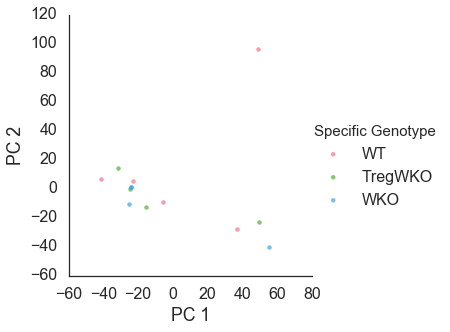

In [29]:
with sns.color_palette(sns.color_palette("hls", 2)):
    with sns.axes_style("white"):
        sns.lmplot(x='PC 1', y='PC 2', data=pca_t_l.append(pca_t_l.iloc[9,:]), #sns.lmplot(x='PC 1', y='PC 2', data=pca_t_l,
                   hue='Specific Genotype', palette=None,
                   fit_reg=False,
                   scatter_kws={'alpha':0.7}
                  );

# Feature Selection

## LogisticRegression method

- ran this a couple times manually and got varying numbers of features retained
- I decided to 
    - run it 100 times
    - count how frequently each feature is retained
    - keep the top X number of them

In [30]:
rlgrg = RandomizedLogisticRegression(C=1, scaling=0.5, 
                                      sample_fraction=0.70, n_resampling=200, 
                                      verbose=False, normalize=False, 
                                      random_state=None, n_jobs=1, )
# rlgrg.fit(X_, y_)
 



In [54]:
itr = 20
f_sel_db = feature_selection.consensus_top10pct_feature_selection(X=X, y=y_geno_encoded_spc,
                                                      clf=rlgrg, names=None, iters=itr)

In [55]:
len(f_sel_db)

2906

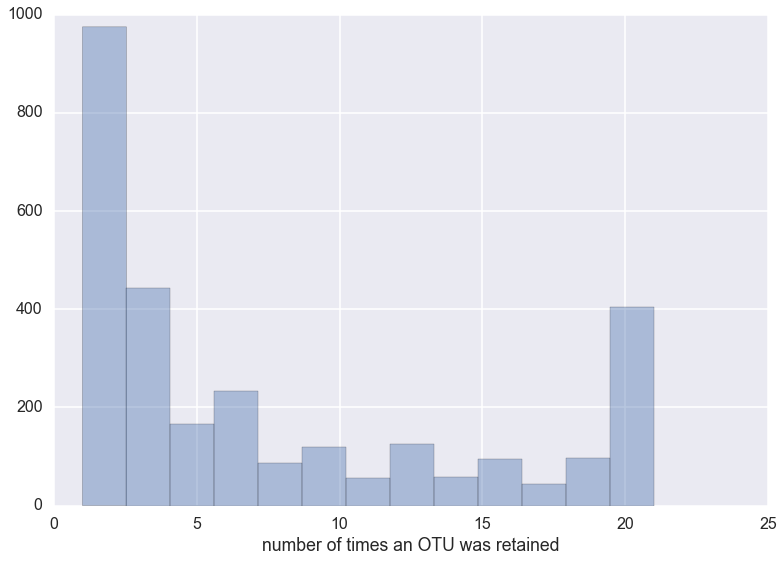

In [56]:
sns.distplot([len(l) for l in f_sel_db.values()], kde=False)
plt.xlabel('number of times an OTU was retained');

### Look at the OTUs that were retained at least X times

In [57]:
my_otus = feature_selection.process_retained_features(retained=f_sel_db, iters=itr)
my_otus.head()

,avg_score,feature_names,retention_rate
0,0.011000,New.CleanUp.ReferenceOTU36017,0
1,0.005000,New.CleanUp.ReferenceOTU5583,0
2,0.005000,New.CleanUp.ReferenceOTU4851,0
3,0.016333,New.CleanUp.ReferenceOTU33513,0
4,0.010833,New.CleanUp.ReferenceOTU34500,0


In [58]:
my_otus.tail()

,avg_score,feature_names,retention_rate
2901,0.021000,New.CleanUp.ReferenceOTU29220,1
2902,0.012917,New.CleanUp.ReferenceOTU29226,0
2903,0.012500,New.CleanUp.ReferenceOTU27386,0
2904,0.005000,New.CleanUp.ReferenceOTU49223,0
2905,0.010000,New.CleanUp.ReferenceOTU45210,0


In [70]:
my_otus_ = my_otus.sort_values(by='avg_score', axis=0, ascending=False).query("""retention_rate > 0.75 """)
my_otus_ = my_otus_.query("""avg_score > 0.01 """)
my_otus_.shape

(404, 3)

In [71]:
my_otus_.head()

,avg_score,feature_names,retention_rate
2384,0.363571,New.CleanUp.ReferenceOTU53528,1
1536,0.305952,New.CleanUp.ReferenceOTU47290,1
894,0.279524,New.CleanUp.ReferenceOTU46426,1
912,0.257143,New.CleanUp.ReferenceOTU30331,1
2140,0.249762,New.CleanUp.ReferenceOTU3397,1


In [72]:
my_otus_.tail()

,avg_score,feature_names,retention_rate
1714,0.01375,New.CleanUp.ReferenceOTU53827,1
2477,0.01250,New.CleanUp.ReferenceOTU5566,1
7,0.01200,New.CleanUp.ReferenceOTU9037,1
1781,0.01100,New.CleanUp.ReferenceOTU53175,1
2316,0.01075,New.CleanUp.ReferenceOTU6719,1


In [73]:
X_best = X[my_otus_.feature_names.values]
X_best.shape

(12, 404)

In [74]:
top_n_sorted_features = 10

# pca = PCA(n_components=2, whiten=False)
pca = RandomizedPCA(n_components=2, whiten=False)

pca_t = pca.fit_transform(X_best.iloc[:,:top_n_sorted_features],y_geno_encoded_spc)
top_n_comp = 2
print('explained_variance_ratio_ of top {num}: {val}'.format(num=top_n_comp,val=pca.explained_variance_ratio_[:top_n_comp].sum()))

pca_t_l = pandas_helpers.repandasify(array=pca_t, y_names=geno_encoder.inverse_transform(y_geno_encoded_spc), X_names=['PC {v_}'.format(v_=v+1) for v in range(len(pca_t[0]))])
print(pca_t_l)

explained_variance_ratio_ of top 2: 0.951516832303
             PC 1      PC 2
WT      -1.671355 -1.686740
WT      -1.563383 -1.236054
TregWKO -1.424953  2.159380
WT      -1.526828 -1.083472
WKO      4.524917 -0.639644
WKO      4.260435  0.518406
TregWKO -1.181174  1.635776
WT      -1.567141 -1.251744
WT      -1.641488 -1.562072
WKO      4.692635 -0.113817
TregWKO -1.429026  2.249329
TregWKO -1.472638  1.010652


In [75]:
pca_t_l = pandas_helpers.repandasify(array=pca_t, y_names=geno_encoder.inverse_transform(y_geno_encoded_spc), X_names=['PC {v_}'.format(v_=v+1) for v in range(len(pca_t[0]))])

pca_t_l['geno'] = pca_t_l.index.values
pca_t_l = pca_t_l.reset_index(drop=True)
pca_t_l['Cage'] = full_table.Cage.astype(str)
pca_t_l['Sex'] = full_table.Gender
pca_t_l['Specific Genotype'] = full_table.Genotype1
# pca_t_l

In [76]:
plot_alpha = 0.7

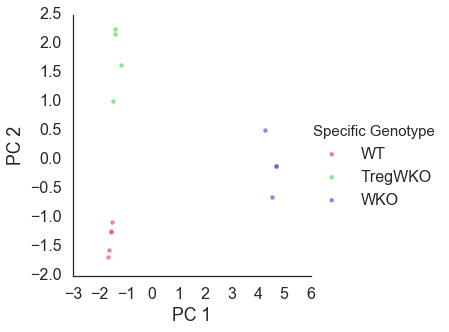

In [77]:
with sns.color_palette(sns.color_palette("hls", 3)):
    with sns.axes_style("white"):
        sns.lmplot(x='PC 1', y='PC 2', data=pca_t_l.append(pca_t_l.iloc[9,:]), #sns.lmplot(x='PC 1', y='PC 2', data=pca_t_l,
                   hue='Specific Genotype', palette=None,
                   fit_reg=False,
                   scatter_kws={'alpha':plot_alpha}
                  );

# Write top 10 OTUs to file for Amy

In [78]:
out_path = "/home/gus/MEGAsync/zim/main/BCH/Projects/Amy/2016-01-07_~_16s_data/top_10_OTUs_3_genotypes.xls"

In [79]:
top_10 = my_otus_0_001.iloc[:10,:]
# top_10.to_excel(out_path,index=False,)

# Test crossvalidation results and preditions on reduced data

In [82]:
X_reduced = X[top_10.feature_names.values.astype(str)]

In [83]:
X_reduced

,New.CleanUp.ReferenceOTU53528,New.CleanUp.ReferenceOTU47290,New.CleanUp.ReferenceOTU46426,New.CleanUp.ReferenceOTU30331,New.CleanUp.ReferenceOTU6688,New.CleanUp.ReferenceOTU25864,New.CleanUp.ReferenceOTU6254,New.CleanUp.ReferenceOTU30569,New.CleanUp.ReferenceOTU38930,New.CleanUp.ReferenceOTU37506
0,1.575649,-0.631472,-0.916997,-0.552009,-0.552009,-0.552009,-0.552009,-0.552009,-0.552009,-0.552009
1,0.792982,-0.631472,-0.916997,-0.552009,-0.552009,-0.552009,-0.552009,-0.552009,-0.552009,-0.552009
2,-0.988355,1.782478,0.756019,-0.552009,-0.552009,-0.552009,-0.552009,-0.552009,-0.552009,-0.552009
3,0.528005,-0.631472,-0.916997,-0.552009,-0.552009,-0.552009,-0.552009,-0.552009,-0.552009,-0.552009
4,-0.988355,-0.631472,-0.916997,1.715908,1.715908,1.715908,1.715908,1.715908,1.715908,1.715908
5,-0.988355,-0.631472,1.116152,1.514480,1.514480,1.514480,1.514480,1.514480,1.514480,1.514480
6,-0.988355,0.426344,1.282398,-0.552009,-0.552009,-0.552009,-0.552009,-0.552009,-0.552009,-0.552009
7,0.820229,-0.631472,-0.916997,-0.552009,-0.552009,-0.552009,-0.552009,-0.552009,-0.552009,-0.552009
8,1.359148,-0.631472,-0.916997,-0.552009,-0.552009,-0.552009,-0.552009,-0.552009,-0.552009,-0.552009
9,0.246266,-0.631472,1.335765,1.737694,1.737694,1.737694,1.737694,1.737694,1.737694,1.737694


## split data into training and testing

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y_geno_encoded_spc,
                                                    test_size=0.33, random_state=42,
                                                   )

In [85]:
y_geno_encoded_spc

array([2, 2, 0, 2, 1, 1, 0, 2, 2, 1, 0, 0])

In [86]:
X_reduced

,New.CleanUp.ReferenceOTU53528,New.CleanUp.ReferenceOTU47290,New.CleanUp.ReferenceOTU46426,New.CleanUp.ReferenceOTU30331,New.CleanUp.ReferenceOTU6688,New.CleanUp.ReferenceOTU25864,New.CleanUp.ReferenceOTU6254,New.CleanUp.ReferenceOTU30569,New.CleanUp.ReferenceOTU38930,New.CleanUp.ReferenceOTU37506
0,1.575649,-0.631472,-0.916997,-0.552009,-0.552009,-0.552009,-0.552009,-0.552009,-0.552009,-0.552009
1,0.792982,-0.631472,-0.916997,-0.552009,-0.552009,-0.552009,-0.552009,-0.552009,-0.552009,-0.552009
2,-0.988355,1.782478,0.756019,-0.552009,-0.552009,-0.552009,-0.552009,-0.552009,-0.552009,-0.552009
3,0.528005,-0.631472,-0.916997,-0.552009,-0.552009,-0.552009,-0.552009,-0.552009,-0.552009,-0.552009
4,-0.988355,-0.631472,-0.916997,1.715908,1.715908,1.715908,1.715908,1.715908,1.715908,1.715908
5,-0.988355,-0.631472,1.116152,1.514480,1.514480,1.514480,1.514480,1.514480,1.514480,1.514480
6,-0.988355,0.426344,1.282398,-0.552009,-0.552009,-0.552009,-0.552009,-0.552009,-0.552009,-0.552009
7,0.820229,-0.631472,-0.916997,-0.552009,-0.552009,-0.552009,-0.552009,-0.552009,-0.552009,-0.552009
8,1.359148,-0.631472,-0.916997,-0.552009,-0.552009,-0.552009,-0.552009,-0.552009,-0.552009,-0.552009
9,0.246266,-0.631472,1.335765,1.737694,1.737694,1.737694,1.737694,1.737694,1.737694,1.737694


## SVM classifier

In [87]:
svc_param_grid = {'svc__C': 10. ** np.arange(-3, 3),
                  'svc__gamma': 10. ** np.arange(-3, 3)
                 }



svc_pipe = make_pipeline(SVC(kernel='linear', random_state=42))

# run the gridsearch to tune the hyper-parameters
svc_grid = GridSearchCV(svc_pipe, param_grid=svc_param_grid, cv=3)

svc_grid.fit(X_train, y_train)
print(svc_grid.best_params_)


# generate and plot confusion matrices
svc_cm = confusion_matrix(y_test,svc_grid.predict(X_test))



{'svc__gamma': 0.001, 'svc__C': 0.10000000000000001}


/home/gus/anaconda2/envs/stack2/lib/python2.7/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=3.
  % (min_labels, self.n_folds)), Warning)


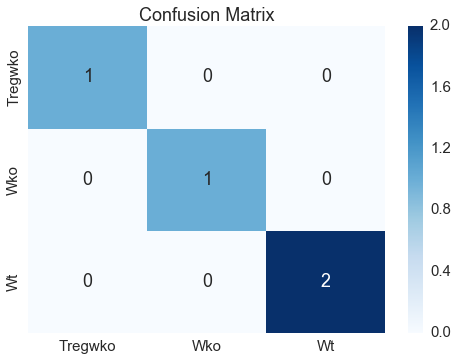

In [90]:
# Non-normalized
model_assessment.plot_confusion_matrix(cm=svc_cm, labels=geno_encoder.classes_, cmap='Blues', title=None,
                 norm=False, context=None, annot=True);


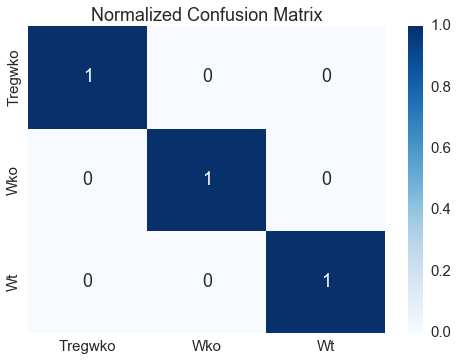

In [91]:
# Normalized
model_assessment.plot_confusion_matrix(cm=svc_cm, labels=geno_encoder.classes_, cmap='Blues', title=None,
                 norm=True, context=None, annot=True);

## RandomForest classifier

In [92]:
rfst_param_grid = {'randomforestclassifier__n_estimators': np.arange(1,15,),
                   'randomforestclassifier__min_samples_leaf': np.arange(1,10,2)
                  }



rfst_pipe = make_pipeline(RandomForestClassifier(random_state=42,n_jobs=8))

# run the gridsearch to tune the hyper-parameters
rfst_grid = GridSearchCV(rfst_pipe, param_grid=rfst_param_grid, cv=3)


rfst_grid.fit(X_train, y_train)
print(rfst_grid.best_params_)


# generate and plot confusion matrices
rfst_cm = confusion_matrix(y_test,rfst_grid.predict(X_test))

{'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__n_estimators': 4}


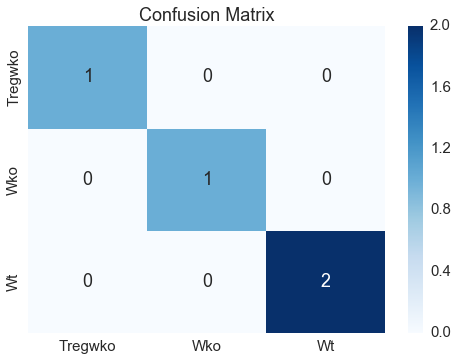

In [93]:
# Non-normalized
model_assessment.plot_confusion_matrix(cm=svc_cm, labels=geno_encoder.classes_, cmap='Blues', title=None,
                 norm=False, context=None, annot=True);

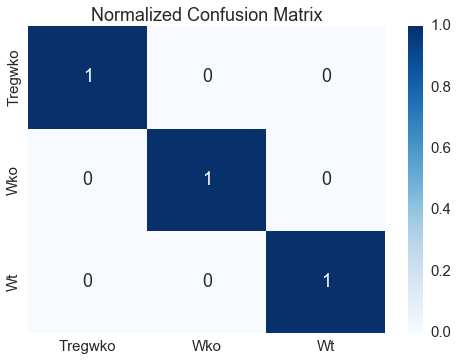

In [95]:
# Normalized
model_assessment.plot_confusion_matrix(cm=svc_cm, labels=geno_encoder.classes_, cmap='Blues', title=None,
                 norm=True, context=None, annot=True);

## LogisticRegression classifier